In [3]:
import pandas as pd
import os
from skimage import io
import torch
import torchvision.models as models
from torch import nn
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [12]:
from PIL import Image
from IPython.display import display

def visualize_image(image_path):
    img = Image.open(image_path)
    display(img)

101424


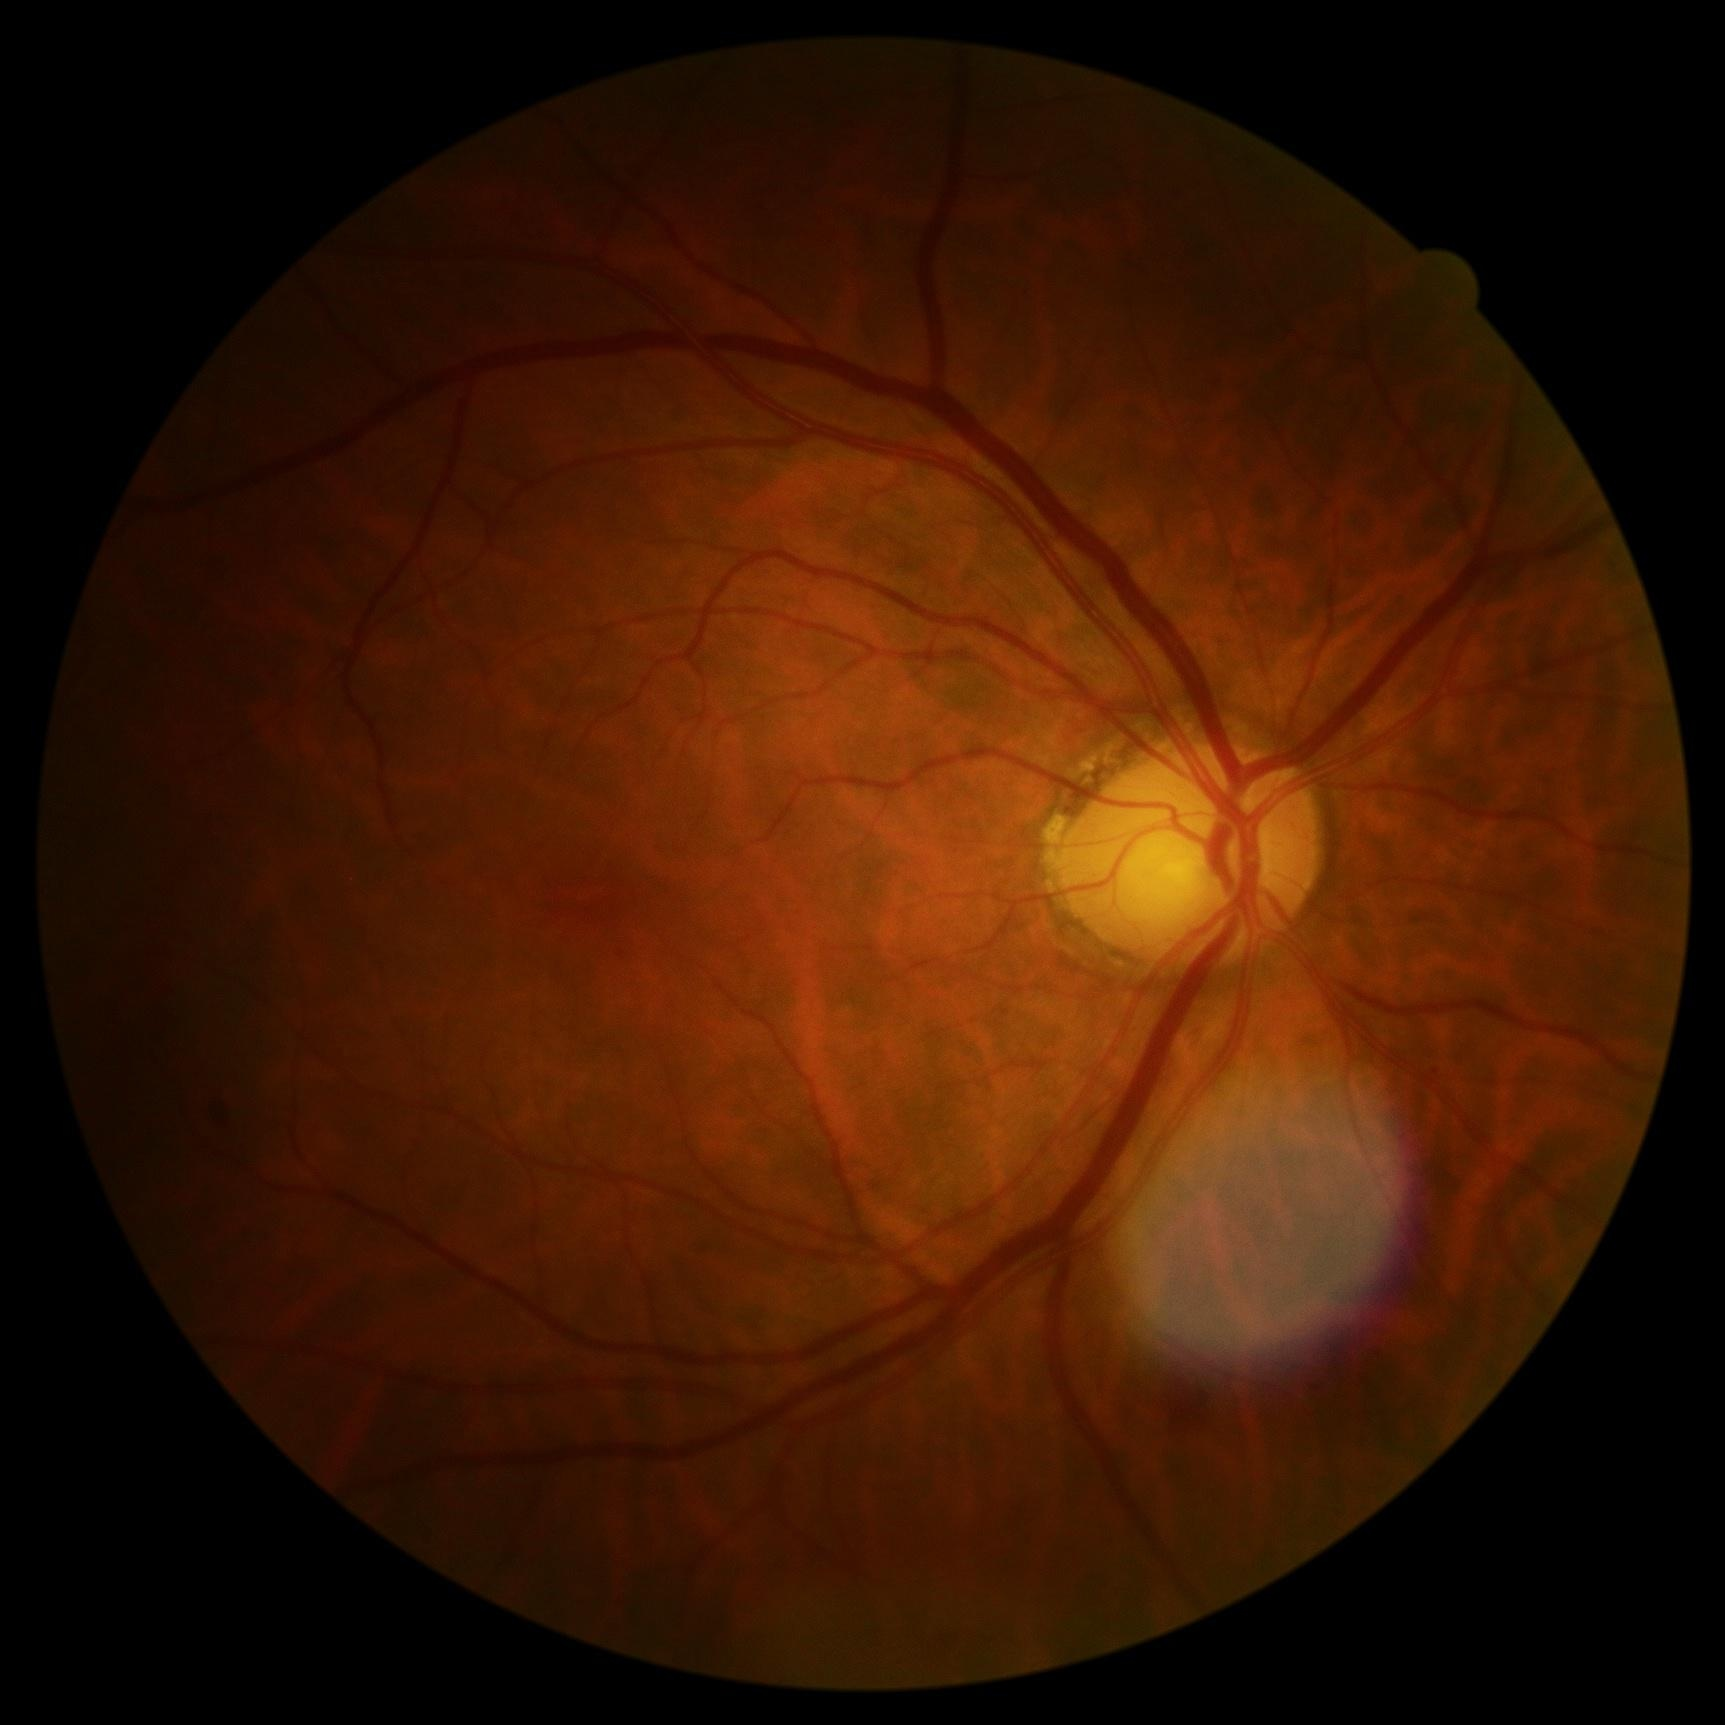

In [14]:
path = 'data/'
print(len(os.listdir(path)))
image_path = path + os.listdir(path)[3]
visualize_image(image_path)

In [15]:
class Dataset_Raigs(Dataset):
    def __init__(self,csv_file,root_dir,transform=None,train=True):
        img_list = os.listdir(root_dir)
        img_list = [i.replace(".JPG","") for i in img_list]
        df = pd.read_csv(csv_file,sep=';')
        df = df[df['Eye ID'].isin(img_list)].reset_index(drop=True)
        train_df, test_df = train_test_split(df, test_size=0.2,stratify=df['Final Label'], random_state=41)
        if(train):
            self.annotations = train_df
            self.root_dir = root_dir
            self.transform = transform
        else:
            self.annotations = test_df
            self.root_dir = root_dir
            self.transform = transform
            
    def __len__(self):
        return len(self.annotations) # 25000
    
    def __getitem__(self,index):
        image_path = os.path.join(self.root_dir,self.annotations.iloc[index,0]+'.JPG')
        image = io.imread(image_path)
        y_label = self.annotations.iloc[index,1]
        int_label = 0 if y_label == "NRG" else 1
        
        if self.transform:
            image = self.transform(image)
        
        return (image,int_label)

In [16]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(255),
                                transforms.RandomResizedCrop(224),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor()])

In [17]:
dataset = Dataset_Raigs("JustRAIGS_Train_labels.csv","data/",transform)

In [18]:
img , y = dataset.__getitem__(1)

In [19]:
img.shape

torch.Size([3, 224, 224])

In [13]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=True)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.pretrained = models.vgg16(pretrained=True)
        self.my_new_layers = nn.Sequential(nn.Linear(1000, 100),
                                           nn.ReLU(),
                                           nn.Linear(100, 2))
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.my_new_layers(x)
        return x

In [16]:
model = MyModel()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [18]:
def check_output(model):
    x = torch.randn(1, 3, 224, 224)
    assert model(x).shape[1] == 2
check_output(model)

In [19]:
model = model.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    #best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            dataset_sizes = dataset.__len__()
            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------


In [1]:
import os

In [4]:
len(os.listdir('./data'))

101424

In [10]:
import ray

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
df = pd.read_csv('JustRAIGS_Train_labels.csv',sep=';')

In [25]:
df.head(2)

,Eye ID,Final Label,Fellow Eye ID,Age,Label G1,Label G2,Label G3,G1 ANRS,G1 ANRI,G1 RNFLDS,...,G3 ANRS,G3 ANRI,G3 RNFLDS,G3 RNFLDI,G3 BCLVS,G3 BCLVI,G3 NVT,G3 DH,G3 LD,G3 LC
0,TRAIN000000,NRG,TRAIN081848,48.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TRAIN000001,NRG,TRAIN018312,29.0,NRG,NRG,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df.shape

(101423, 37)

In [48]:
train.shape

(81138, 37)

In [49]:
test.shape

(20285, 37)

In [2]:
import os
os.getcwd()

'/workspace/shrey/Glucoma_Major'

In [1]:
import ray
ray.init()
from pprint import pprint
pprint(ray.nodes())

2024-04-22 07:48:28,922	INFO worker.py:1567 -- Connecting to existing Ray cluster at address: 172.17.0.4:6379...
2024-04-22 07:48:28,934	INFO worker.py:1743 -- Connected to Ray cluster. View the dashboard at http://172.17.0.4:5000 


[{'Alive': True,
  'Labels': {'ray.io/node_id': '13540d935db8621156c7157509d9da38202d84e65c6555cc06d2cc0c'},
  'MetricsExportPort': 64332,
  'NodeID': '13540d935db8621156c7157509d9da38202d84e65c6555cc06d2cc0c',
  'NodeManagerAddress': '172.17.0.4',
  'NodeManagerHostname': '2d253b84a45e',
  'NodeManagerPort': 42033,
  'NodeName': '172.17.0.4',
  'ObjectManagerPort': 42657,
  'ObjectStoreSocketName': '/tmp/ray/session_2024-04-22_07-30-32_933014_1121/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2024-04-22_07-30-32_933014_1121/sockets/raylet',
  'Resources': {'CPU': 40.0,
                'GPU': 4.0,
                'accelerator_type:V100': 1.0,
                'memory': 249601316864.0,
                'node:172.17.0.4': 1.0,
                'node:__internal_head__': 1.0,
                'object_store_memory': 10000000000.0},
  'RuntimeEnvAgentPort': 56573,
  'alive': True}]
(raylet) The autoscaler failed with the following error:
Terminated with signal 15
  File "/opt/co